In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Configuración
sns.set_style("whitegrid")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

https://www.kaggle.com/datasets/hghdhygf/brain-tumor-mri-image-dataset
Revisar ese set de datos glioma, pituitary, no tumor, meningioma

In [2]:
# Datos y paths (ajusta según tu estructura)
base_path = "images"
categories = ["Healthy", "Tumor"]
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_paths.append(os.path.join(category_path, image_name))
            labels.append(category)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Codificación de etiquetas
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [4]:
# División en entrenamiento, validación y prueba
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(
    df[['image_path']], df['category_encoded'], train_size=0.8, shuffle=True, random_state=42, stratify=df['category_encoded']
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42, stratify=y_temp
)

In [5]:
# Re-muestreo para balancear
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_orig, y_train_orig)

train_df = pd.DataFrame({'image_path': X_train_resampled['image_path'], 'label': y_train_resampled})
train_df['label'] = train_df['label'].astype(str)
valid_df = pd.DataFrame({'image_path': X_valid['image_path'], 'label': y_valid.astype(str)})
test_df = pd.DataFrame({'image_path': X_test['image_path'], 'label': y_test.astype(str)})

In [6]:
# Dataset personalizado
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = int(self.df.iloc[idx]['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformaciones
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# DataLoaders
batch_size = 32
train_dataset = BrainTumorDataset(train_df, transform=train_transform)
valid_dataset = BrainTumorDataset(valid_df, transform=valid_test_transform)
test_dataset = BrainTumorDataset(test_df, transform=valid_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Initialize training history lists
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Variable to track epoch count before fine-tuning
initial_epochs = 0

# Función para congelar/descongelar capas
def set_parameter_requires_grad(model, feature_extracting=True):
    for param in model.parameters():
        param.requires_grad = not feature_extracting

# Carga y reemplazo del modelo preentrenado
model = models.resnet50(pretrained=True)

# Fase 1: Congelar todas las capas, entrenar solo la capa final
set_parameter_requires_grad(model, feature_extracting=True)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

model = model.to(device)

c:\Users\sergi\OneDrive\Documentos\Deep_learning\ML_tumours_v2\tumours\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sergi\OneDrive\Documentos\Deep_learning\ML_tumours_v2\tumours\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Entrenamiento fase 1
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
num_epochs = 10
best_auc = 0
patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total

    # Validación
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            probs = outputs.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

            preds = (outputs > 0.5).long()
            val_correct += (preds == labels.long()).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    val_auc = auc(fpr, tpr)

    # Append metrics to history lists
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    val_loss_history.append(val_epoch_loss)
    val_acc_history.append(val_epoch_acc)

    print(f"Epoch {epoch+1}: Train loss {epoch_loss:.4f}, Acc {epoch_acc:.4f} | Val loss {val_epoch_loss:.4f}, Acc {val_epoch_acc:.4f}, AUC {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model_phase1.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping en fase 1")
            break

# Guardar cuántas epochs se completaron en fase 1
initial_epochs = epoch + 1  # La última epoch hecha

# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model_phase1.pth'))

Epoch 1: Train loss 0.1905, Acc 0.9326 | Val loss 0.1554, Acc 0.9473, AUC 0.9922
Epoch 2: Train loss 0.1432, Acc 0.9493 | Val loss 0.0998, Acc 0.9674, AUC 0.9939
Epoch 3: Train loss 0.1435, Acc 0.9497 | Val loss 0.1114, Acc 0.9634, AUC 0.9943
Epoch 4: Train loss 0.1459, Acc 0.9502 | Val loss 0.0789, Acc 0.9734, AUC 0.9946
Epoch 5: Train loss 0.1406, Acc 0.9494 | Val loss 0.0916, Acc 0.9686, AUC 0.9946
Epoch 6: Train loss 0.1398, Acc 0.9518 | Val loss 0.0944, Acc 0.9678, AUC 0.9947
Epoch 7: Train loss 0.1431, Acc 0.9482 | Val loss 0.1531, Acc 0.9453, AUC 0.9950
Epoch 8: Train loss 0.1444, Acc 0.9493 | Val loss 0.0918, Acc 0.9718, AUC 0.9952
Epoch 9: Train loss 0.1413, Acc 0.9505 | Val loss 0.1185, Acc 0.9598, AUC 0.9951
Epoch 10: Train loss 0.1433, Acc 0.9481 | Val loss 0.1130, Acc 0.9638, AUC 0.9948


C:\Users\sergi\AppData\Local\Temp\ipykernel_24280\1102824021.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_phase1.pth'))


<All keys matched successfully>

In [9]:
# Fase 2: Descongelar capas específicas para fine-tuning más profundo
set_parameter_requires_grad(model, feature_extracting=True)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Entrenamiento en fase 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total

    # Validación
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            probs = outputs.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

            preds = (outputs > 0.5).long()
            val_correct += (preds == labels.long()).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    val_auc = auc(fpr, tpr)

    # Append metrics
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    val_loss_history.append(val_epoch_loss)
    val_acc_history.append(val_epoch_acc)

    print(f"Fine-tune Epoch {epoch+1}: Train loss {epoch_loss:.4f}, Acc {epoch_acc:.4f} | Val loss {val_epoch_loss:.4f}, Acc {val_epoch_acc:.4f}, AUC {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model_phase2.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping en fase 2")
            break

# Guardar el modelo final
torch.save(model.state_dict(), 'best_model_final.pth')

Fine-tune Epoch 1: Train loss 0.0390, Acc 0.9883 | Val loss 0.0102, Acc 0.9960, AUC 1.0000
Fine-tune Epoch 2: Train loss 0.0123, Acc 0.9964 | Val loss 0.0135, Acc 0.9952, AUC 0.9999
Fine-tune Epoch 3: Train loss 0.0061, Acc 0.9981 | Val loss 0.0056, Acc 0.9976, AUC 1.0000
Fine-tune Epoch 4: Train loss 0.0119, Acc 0.9972 | Val loss 0.0008, Acc 1.0000, AUC 1.0000
Fine-tune Epoch 5: Train loss 0.0053, Acc 0.9984 | Val loss 0.0014, Acc 0.9992, AUC 1.0000
Fine-tune Epoch 6: Train loss 0.0044, Acc 0.9986 | Val loss 0.0052, Acc 0.9980, AUC 1.0000
Fine-tune Epoch 7: Train loss 0.0038, Acc 0.9989 | Val loss 0.0027, Acc 0.9992, AUC 1.0000
Fine-tune Epoch 8: Train loss 0.0036, Acc 0.9991 | Val loss 0.0004, Acc 1.0000, AUC 1.0000
Fine-tune Epoch 9: Train loss 0.0040, Acc 0.9992 | Val loss 0.0019, Acc 0.9996, AUC 1.0000
Early stopping en fase 2


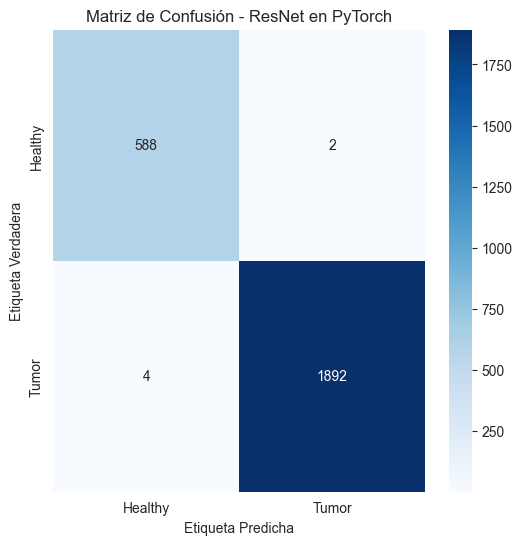

              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       590
       Tumor       1.00      1.00      1.00      1896

    accuracy                           1.00      2486
   macro avg       1.00      1.00      1.00      2486
weighted avg       1.00      1.00      1.00      2486



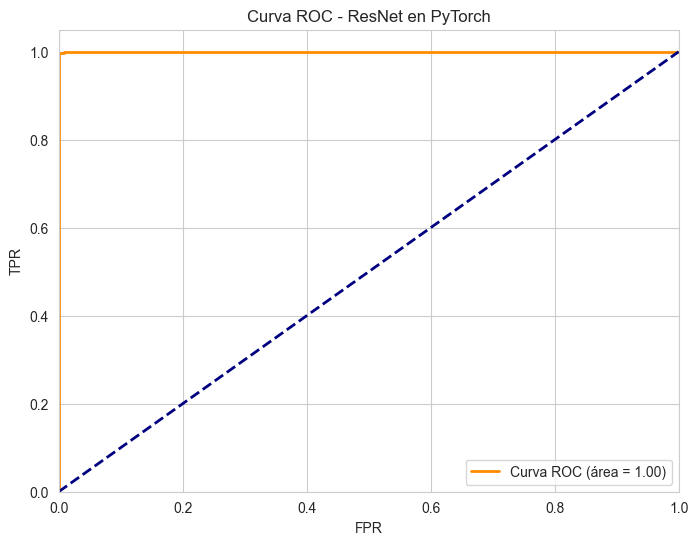

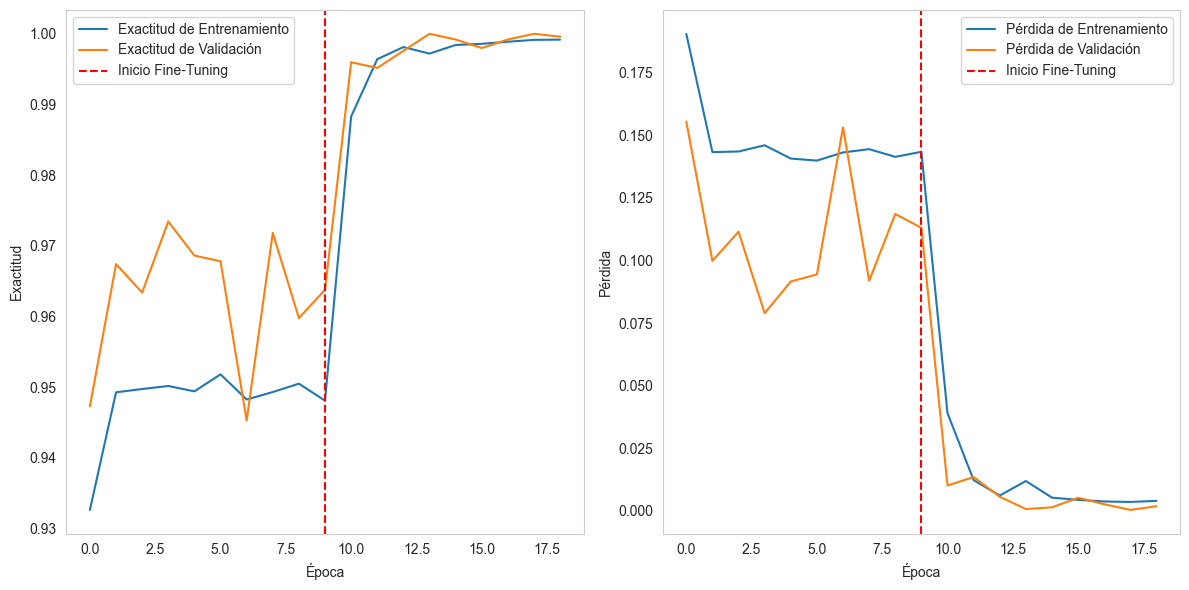

In [10]:
# Evaluación en el conjunto de prueba
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images).squeeze()
        probs = outputs.cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Convertir a numpy arrays
y_probs = np.array(all_probs)
y_true = np.array(all_labels).astype(int)

# Predicciones
y_pred = (y_probs > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión - ResNet en PyTorch')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - ResNet en PyTorch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Función de trazado de historia de entrenamiento
def plot_training_history(train_acc, val_acc, train_loss, val_loss, initial_epochs):
    plt.figure(figsize=(12, 6))
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Exactitud de Entrenamiento')
    plt.plot(val_acc, label='Exactitud de Validación')
    # Línea que indica inicio fine-tuning
    plt.axvline(x=initial_epochs - 1, color='red', linestyle='--', label='Inicio Fine-Tuning')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()
    plt.grid()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Pérdida de Entrenamiento')
    plt.plot(val_loss, label='Pérdida de Validación')
    plt.axvline(x=initial_epochs - 1, color='red', linestyle='--', label='Inicio Fine-Tuning')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Finalmente, trazamos la historia completa
plot_training_history(train_acc_history, val_acc_history, train_loss_history, val_loss_history, initial_epochs)